In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lmphoton.simulation import current_simulation as sim
import lmtimesim
from tqdm import tqdm

from scipy import constants as const
from scipy import interpolate
import scipy

import pandas as pd

In [2]:
from lmtimesim.components.Filters.crr import CongoCRR as CRR
crr = CRR()

crr.sim = sim()

um = 1e-6

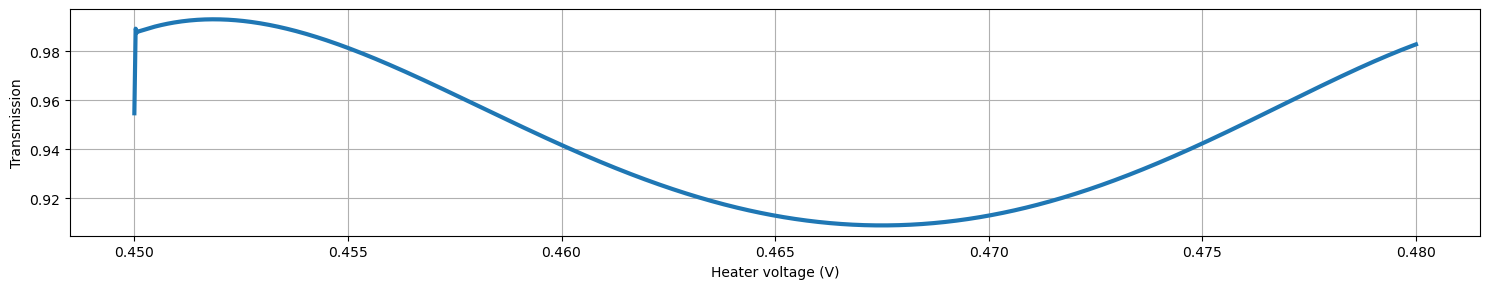

Middle of dip voltage 0.4675075075075075


In [3]:
# Align the CRR to 1310nm center wavelength
heater_voltage_sweep = np.linspace(0.45,0.48,num=1000)
drop_port_storage = []

sim().wavelength = 1310e-9
crr._wavelength = 1310e-9

crr.bottom_ring_heater_voltage = np.min(heater_voltage_sweep)
crr.top_ring_heater_voltage = np.min(heater_voltage_sweep)
crr.drop_port_transmission()

for v in heater_voltage_sweep:
    crr.bottom_ring_heater_voltage = v
    crr.top_ring_heater_voltage = v
    drop_port_storage.append(crr.drop_port_transmission())
    
drop_port_storage = np.array(drop_port_storage)

plt.figure(figsize=(15,3))
plt.plot(heater_voltage_sweep,drop_port_storage, linewidth=3.0)
plt.xlabel("Heater voltage (V)")
plt.ylabel("Transmission")
plt.grid(True)
plt.tight_layout()
plt.show()

voltage_to_park_at_center = heater_voltage_sweep[np.argmin(drop_port_storage)]
print(f"Middle of dip voltage {voltage_to_park_at_center}")

crr.bottom_ring_heater_voltage = voltage_to_park_at_center
crr.top_ring_heater_voltage = voltage_to_park_at_center

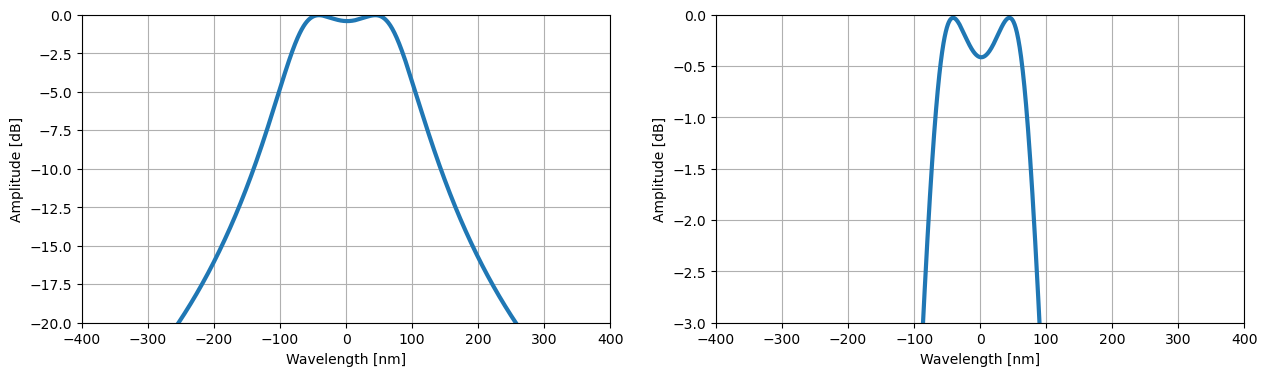

In [4]:
# # Do broad wavelength sweeps of the CRR
wavelengths = np.linspace(1.298, 1.322, 10000)*um
frequencies = const.c/wavelengths


baseline_wavelength = 1310e-9
baseline_frequency = const.c/baseline_wavelength
baseline_wavelength = const.c/baseline_frequency

#Create a CRR spectrum to compare
drop_port_storage = []

for wavelength in wavelengths:
    sim().wavelength = wavelength
    crr._wavelength = wavelength
    drop_port_storage.append(crr.drop_port_transmission())

drop_port_storage = np.array(drop_port_storage)

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot((frequencies - baseline_frequency)/1e9,10*np.log10(drop_port_storage), linewidth=3.0)
plt.xlim(-400, 400)
plt.ylim(-20, 0)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Amplitude [dB]")
plt.grid(True)
plt.subplot(1,2,2)
plt.plot((frequencies - baseline_frequency)/1e9,10*np.log10(drop_port_storage), linewidth=3.0)
plt.xlim(-400, 400)
plt.ylim(-3,0)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Amplitude [dB]")
plt.grid(True)
plt.show()

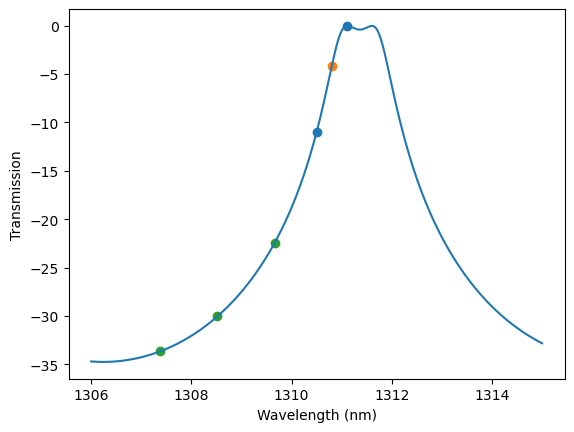

Insertion loss (dB):  -0.03017803200802412
Crosstalk at 200GHz from center (dB):  -22.454728930267454
Crosstalk at 400GHz from center (dB):  -30.04671943430271
Crosstalk at 600GHz from center (dB):  -33.65540519870821
Passband Ripple (dB):  -4.0986547104790585
1dB Bandwidth (nm):  0.616808404202458
3dB Bandwidth (nm):  0.616808404202458


In [10]:
#Crosstalk/shape test
#Sweep laser over resonance, measure attenuation some distance away from resonance
# Show voltage tuning of the CRR
wavelengths = np.linspace(1.306, 1.315, 2000)*um
crr.bottom_ring_heater_voltage = 0.55
crr.top_ring_heater_voltage = 0.55

wav_sweep_storage = []
for wavelength in wavelengths:
    sim().wavelength = wavelength
    wav_sweep_storage.append(crr.drop_port_transmission())

wav_sweep_storage = np.array(wav_sweep_storage)

#Find the center of the CRR spectrum
first_peak_arg = np.argmax(wav_sweep_storage[0:len(wav_sweep_storage)//2])
first_peak = wavelengths[first_peak_arg]
second_peak_arg = np.argmax(wav_sweep_storage[len(wav_sweep_storage)//2:]) + len(wav_sweep_storage)//2
second_peak = wavelengths[second_peak_arg]

center_wavelength_arg = int((first_peak_arg + second_peak_arg)/2)
center_wavelength = (first_peak+second_peak)/2

crosstalk_200GHz_wavelength = center_wavelength - 200e9/(3e8/(1310e-9))*1310e-9
crosstalk_200GHz_arg        = np.argmin(np.abs(wavelengths - crosstalk_200GHz_wavelength))
crosstalk_400GHz_wavelength = center_wavelength - 400e9/(3e8/(1310e-9))*1310e-9
crosstalk_400GHz_arg        = np.argmin(np.abs(wavelengths - crosstalk_400GHz_wavelength))
crosstalk_600GHz_wavelength = center_wavelength - 600e9/(3e8/(1310e-9))*1310e-9
crosstalk_600GHz_arg        = np.argmin(np.abs(wavelengths - crosstalk_600GHz_wavelength))

plt.figure()
plt.plot(wavelengths*1e9,10*np.log10(wav_sweep_storage))
plt.scatter(first_peak*1e9,10*np.log10(wav_sweep_storage)[first_peak_arg],c='C0')
plt.scatter(second_peak*1e9,10*np.log10(wav_sweep_storage)[second_peak_arg],c='C0')
plt.scatter(center_wavelength*1e9,10*np.log10(wav_sweep_storage)[int((first_peak_arg + second_peak_arg)/2)],c='C1')
plt.scatter(crosstalk_200GHz_wavelength*1e9,10*np.log10(wav_sweep_storage)[crosstalk_200GHz_arg],c='C2')
plt.scatter(crosstalk_400GHz_wavelength*1e9,10*np.log10(wav_sweep_storage)[crosstalk_400GHz_arg],c='C2')
plt.scatter(crosstalk_600GHz_wavelength*1e9,10*np.log10(wav_sweep_storage)[crosstalk_600GHz_arg],c='C2')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")
plt.show()

insertion_loss_dB = np.max(10*np.log10(wav_sweep_storage))
print("Insertion loss (dB): ", insertion_loss_dB)
print("Crosstalk at 200GHz from center (dB): ", 10*np.log10(wav_sweep_storage)[crosstalk_200GHz_arg])
print("Crosstalk at 400GHz from center (dB): ", 10*np.log10(wav_sweep_storage)[crosstalk_400GHz_arg])
print("Crosstalk at 600GHz from center (dB): ", 10*np.log10(wav_sweep_storage)[crosstalk_600GHz_arg])

passband_ripple_dB = 10*np.log10(wav_sweep_storage)[center_wavelength_arg] - insertion_loss_dB
print("Passband Ripple (dB): ", passband_ripple_dB)

bandwidth_1dB_intersection_height = - 1
bandwidth_3dB_intersection_height = - 3
left_1dB_bandwidth_arg = np.argmin(np.abs(10*np.log10(wav_sweep_storage[0:len(wav_sweep_storage)//2]) - bandwidth_1dB_intersection_height))
left_1dB_bandwidth = wavelengths[left_1dB_bandwidth_arg]
bandwidth_1dB = 2*np.abs(left_1dB_bandwidth - center_wavelength)

left_3dB_bandwidth_arg = np.argmin(np.abs(10*np.log10(wav_sweep_storage[0:len(wav_sweep_storage)//2]) - bandwidth_3dB_intersection_height))
left_3dB_bandwidth = wavelengths[left_3dB_bandwidth_arg]
bandwidth_3dB = 2*np.abs(left_3dB_bandwidth - center_wavelength)

print("1dB Bandwidth (nm): ", bandwidth_1dB*1e9)
print("3dB Bandwidth (nm): ", bandwidth_3dB*1e9)

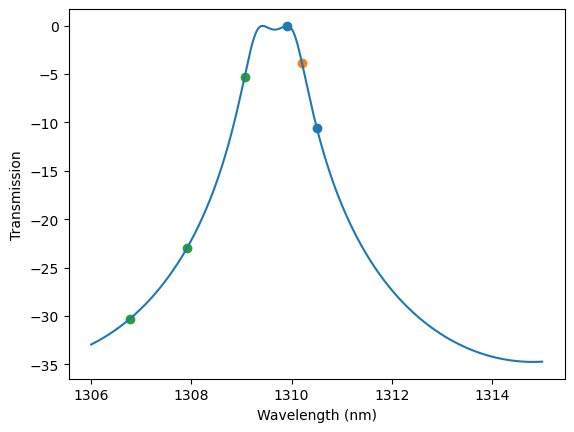

Insertion loss (dB):  -0.030176591979304696
Crosstalk at 200GHz from center (dB):  -5.298042136609109
Crosstalk at 400GHz from center (dB):  -22.924434486733425
Crosstalk at 600GHz from center (dB):  -30.278742119327262
Passband Ripple (dB):  -3.784953398963009
1dB Bandwidth (nm):  0.2881440720359189
3dB Bandwidth (nm):  0.07203601800919149


In [11]:
#Crosstalk/shape test
#Sweep laser over resonance, measure attenuation some distance away from resonance
# Show voltage tuning of the CRR
wavelengths = np.linspace(1.306, 1.315, 2000)*um
crr.bottom_ring_heater_voltage = 0.45
crr.top_ring_heater_voltage = 0.45

wav_sweep_storage = []
for wavelength in wavelengths:
    sim().wavelength = wavelength
    wav_sweep_storage.append(crr.drop_port_transmission())

wav_sweep_storage = np.array(wav_sweep_storage)

#Find the center of the CRR spectrum
first_peak_arg = np.argmax(wav_sweep_storage[0:len(wav_sweep_storage)//2])
first_peak = wavelengths[first_peak_arg]
second_peak_arg = np.argmax(wav_sweep_storage[len(wav_sweep_storage)//2:]) + len(wav_sweep_storage)//2
second_peak = wavelengths[second_peak_arg]

center_wavelength_arg = int((first_peak_arg + second_peak_arg)/2)
center_wavelength = (first_peak+second_peak)/2

crosstalk_200GHz_wavelength = center_wavelength - 200e9/(3e8/(1310e-9))*1310e-9
crosstalk_200GHz_arg        = np.argmin(np.abs(wavelengths - crosstalk_200GHz_wavelength))
crosstalk_400GHz_wavelength = center_wavelength - 400e9/(3e8/(1310e-9))*1310e-9
crosstalk_400GHz_arg        = np.argmin(np.abs(wavelengths - crosstalk_400GHz_wavelength))
crosstalk_600GHz_wavelength = center_wavelength - 600e9/(3e8/(1310e-9))*1310e-9
crosstalk_600GHz_arg        = np.argmin(np.abs(wavelengths - crosstalk_600GHz_wavelength))

plt.figure()
plt.plot(wavelengths*1e9,10*np.log10(wav_sweep_storage))
plt.scatter(first_peak*1e9,10*np.log10(wav_sweep_storage)[first_peak_arg],c='C0')
plt.scatter(second_peak*1e9,10*np.log10(wav_sweep_storage)[second_peak_arg],c='C0')
plt.scatter(center_wavelength*1e9,10*np.log10(wav_sweep_storage)[int((first_peak_arg + second_peak_arg)/2)],c='C1')
plt.scatter(crosstalk_200GHz_wavelength*1e9,10*np.log10(wav_sweep_storage)[crosstalk_200GHz_arg],c='C2')
plt.scatter(crosstalk_400GHz_wavelength*1e9,10*np.log10(wav_sweep_storage)[crosstalk_400GHz_arg],c='C2')
plt.scatter(crosstalk_600GHz_wavelength*1e9,10*np.log10(wav_sweep_storage)[crosstalk_600GHz_arg],c='C2')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")
plt.show()

insertion_loss_dB = np.max(10*np.log10(wav_sweep_storage))
print("Insertion loss (dB): ", insertion_loss_dB)
print("Crosstalk at 200GHz from center (dB): ", 10*np.log10(wav_sweep_storage)[crosstalk_200GHz_arg])
print("Crosstalk at 400GHz from center (dB): ", 10*np.log10(wav_sweep_storage)[crosstalk_400GHz_arg])
print("Crosstalk at 600GHz from center (dB): ", 10*np.log10(wav_sweep_storage)[crosstalk_600GHz_arg])

passband_ripple_dB = 10*np.log10(wav_sweep_storage)[center_wavelength_arg] - insertion_loss_dB
print("Passband Ripple (dB): ", passband_ripple_dB)

bandwidth_1dB_intersection_height = - 1
bandwidth_3dB_intersection_height = - 3
left_1dB_bandwidth_arg = np.argmin(np.abs(10*np.log10(wav_sweep_storage[0:len(wav_sweep_storage)//2]) - bandwidth_1dB_intersection_height))
left_1dB_bandwidth = wavelengths[left_1dB_bandwidth_arg]
bandwidth_1dB = 2*np.abs(left_1dB_bandwidth - center_wavelength)

left_3dB_bandwidth_arg = np.argmin(np.abs(10*np.log10(wav_sweep_storage[0:len(wav_sweep_storage)//2]) - bandwidth_3dB_intersection_height))
left_3dB_bandwidth = wavelengths[left_3dB_bandwidth_arg]
bandwidth_3dB = 2*np.abs(left_3dB_bandwidth - center_wavelength)

print("1dB Bandwidth (nm): ", bandwidth_1dB*1e9)
print("3dB Bandwidth (nm): ", bandwidth_3dB*1e9)

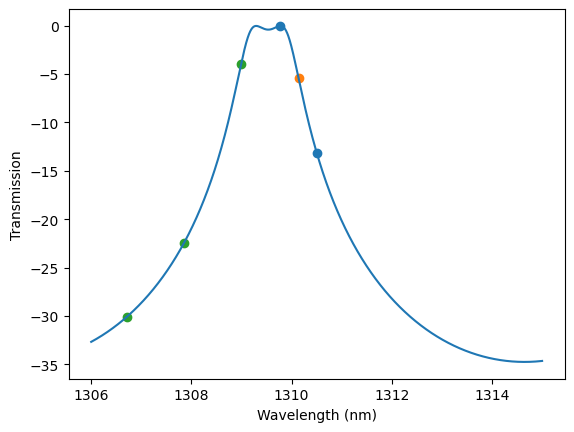

Insertion loss (dB):  -0.03018642306270248
Crosstalk at 200GHz from center (dB):  -3.9235884144069946
Crosstalk at 400GHz from center (dB):  -22.471880801422405
Crosstalk at 600GHz from center (dB):  -30.102508414287804
Passband Ripple (dB):  -5.3715255706498555
1dB Bandwidth (nm):  0.4187093546772873
3dB Bandwidth (nm):  2.2106053026512136


In [12]:
#Crosstalk/shape test
#Sweep laser over resonance, measure attenuation some distance away from resonance
# Show voltage tuning of the CRR
wavelengths = np.linspace(1.306, 1.315, 2000)*um
crr.bottom_ring_heater_voltage = 0.9
crr.top_ring_heater_voltage = 0.9

wav_sweep_storage = []
for wavelength in wavelengths:
    sim().wavelength = wavelength
    wav_sweep_storage.append(crr.drop_port_transmission())

wav_sweep_storage = np.array(wav_sweep_storage)

#Find the center of the CRR spectrum
first_peak_arg = np.argmax(wav_sweep_storage[0:len(wav_sweep_storage)//2])
first_peak = wavelengths[first_peak_arg]
second_peak_arg = np.argmax(wav_sweep_storage[len(wav_sweep_storage)//2:]) + len(wav_sweep_storage)//2
second_peak = wavelengths[second_peak_arg]

center_wavelength_arg = int((first_peak_arg + second_peak_arg)/2)
center_wavelength = (first_peak+second_peak)/2

crosstalk_200GHz_wavelength = center_wavelength - 200e9/(3e8/(1310e-9))*1310e-9
crosstalk_200GHz_arg        = np.argmin(np.abs(wavelengths - crosstalk_200GHz_wavelength))
crosstalk_400GHz_wavelength = center_wavelength - 400e9/(3e8/(1310e-9))*1310e-9
crosstalk_400GHz_arg        = np.argmin(np.abs(wavelengths - crosstalk_400GHz_wavelength))
crosstalk_600GHz_wavelength = center_wavelength - 600e9/(3e8/(1310e-9))*1310e-9
crosstalk_600GHz_arg        = np.argmin(np.abs(wavelengths - crosstalk_600GHz_wavelength))

plt.figure()
plt.plot(wavelengths*1e9,10*np.log10(wav_sweep_storage))
plt.scatter(first_peak*1e9,10*np.log10(wav_sweep_storage)[first_peak_arg],c='C0')
plt.scatter(second_peak*1e9,10*np.log10(wav_sweep_storage)[second_peak_arg],c='C0')
plt.scatter(center_wavelength*1e9,10*np.log10(wav_sweep_storage)[int((first_peak_arg + second_peak_arg)/2)],c='C1')
plt.scatter(crosstalk_200GHz_wavelength*1e9,10*np.log10(wav_sweep_storage)[crosstalk_200GHz_arg],c='C2')
plt.scatter(crosstalk_400GHz_wavelength*1e9,10*np.log10(wav_sweep_storage)[crosstalk_400GHz_arg],c='C2')
plt.scatter(crosstalk_600GHz_wavelength*1e9,10*np.log10(wav_sweep_storage)[crosstalk_600GHz_arg],c='C2')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")
plt.show()

insertion_loss_dB = np.max(10*np.log10(wav_sweep_storage))
print("Insertion loss (dB): ", insertion_loss_dB)
print("Crosstalk at 200GHz from center (dB): ", 10*np.log10(wav_sweep_storage)[crosstalk_200GHz_arg])
print("Crosstalk at 400GHz from center (dB): ", 10*np.log10(wav_sweep_storage)[crosstalk_400GHz_arg])
print("Crosstalk at 600GHz from center (dB): ", 10*np.log10(wav_sweep_storage)[crosstalk_600GHz_arg])

passband_ripple_dB = 10*np.log10(wav_sweep_storage)[center_wavelength_arg] - insertion_loss_dB
print("Passband Ripple (dB): ", passband_ripple_dB)

bandwidth_1dB_intersection_height = - 1
bandwidth_3dB_intersection_height = - 3
left_1dB_bandwidth_arg = np.argmin(np.abs(10*np.log10(wav_sweep_storage[0:len(wav_sweep_storage)//2]) - bandwidth_1dB_intersection_height))
left_1dB_bandwidth = wavelengths[left_1dB_bandwidth_arg]
bandwidth_1dB = 2*np.abs(left_1dB_bandwidth - center_wavelength)

left_3dB_bandwidth_arg = np.argmin(np.abs(10*np.log10(wav_sweep_storage[0:len(wav_sweep_storage)//2]) - bandwidth_3dB_intersection_height))
left_3dB_bandwidth = wavelengths[left_3dB_bandwidth_arg]
bandwidth_3dB = 2*np.abs(left_3dB_bandwidth - center_wavelength)

print("1dB Bandwidth (nm): ", bandwidth_1dB*1e9)
print("3dB Bandwidth (nm): ", bandwidth_3dB*1e9)